# Diffraction Spectrum of a Finite Binary Grating

In this example, we compute the diffraction spectrum of a binary phase [grating](https://en.wikipedia.org/wiki/Diffraction_grating) with finite length. To compute the diffraction spectrum of the infinite periodic structure requires [mode decomposition](https://meep.readthedocs.io/en/latest/Mode_Decomposition/); for a demonstration, see [Tutorials/Mode Decomposition/Diffraction Spectrum of a Binary Grating](https://meep.readthedocs.io/en/latest/Python_Tutorials/Mode_Decomposition/#diffraction-spectrum-of-a-binary-grating) which also describes the grating geometry used in this example (i.e., periodicity of 10 μm, height of 0.5 μm, duty cycle of 0.5, and index 1.5 in air). Note that an infinite periodic structure actually has *no* spatial separation of the diffracted orders; they are all present at every far-field point. The focus of this tutorial is to demonstrate `add_near2far`'s support for periodic boundaries.

The simulation involves computing the scattered near fields of a finite-length grating for an E<sub>z</sub>-polarized, pulsed planewave source spanning wavelengths of 0.4-0.6 μm at normal incidence. The far fields are then computed for 500 points along a line parallel to the grating axis positioned 100 m away (i.e., &#8811; 2D<sup>2</sup>\/λ, the [Fraunhofer distance](https://en.wikipedia.org/wiki/Fraunhofer_distance); D=NΛ where N is the number of unit cells and Λ is the grating periodicity, λ is the source wavelength) in the upper half plane of the symmetric finite structure with length corresponding to a 20° cone. The diffraction spectra is computed as the ratio of the energy density of the far fields from two separate runs: (1) an empty cell to obtain the fields from just the incident planewave and (2) a binary-grating unit cell to obtain the scattered fields.

Modeling a finite grating requires specifying the `nperiods` parameter of `add_near2far` which sums `2*nperiods+1` Bloch-periodic copies of the near fields. However, because of the way in which the edges of the structure are handled, this approach is only an approximation for a finite periodic surface. We will verify that the error from this approximation is O(1/`nperiods`) by comparing its result with that of a true finite periodic structure involving multiple periods in a supercell arrangement terminated with a flat surface extending into PML. (There are infinitely many ways to terminate a finite periodic structure, of course, and different choices will have slightly different errors compared to the periodic approximation.)

In [1]:
import meep as mp
import math
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

resolution = 25  # pixels/μm

dpml = 1.0  # PML thickness
dsub = 3.0  # substrate thickness
dpad = 3.0  # padding between grating and PML
gp = 10.0  # grating period
gh = 0.5  # grating height
gdc = 0.5  # grating duty cycle

nperiods = 10  # number of unit cells in finite periodic grating

ff_distance = 1e8  # far-field distance from near-field monitor
ff_angle = 20  # far-field cone angle
ff_npts = 500  # number of far-field points

ff_length = ff_distance * math.tan(math.radians(ff_angle))
ff_res = ff_npts / ff_length

sx = dpml + dsub + gh + dpad + dpml
cell_size = mp.Vector3(sx)

pml_layers = [mp.PML(thickness=dpml, direction=mp.X)]

symmetries = [mp.Mirror(mp.Y)]

wvl_min = 0.4  # min wavelength
wvl_max = 0.6  # max wavelength
fmin = 1 / wvl_max  # min frequency
fmax = 1 / wvl_min  # max frequency
fcen = 0.5 * (fmin + fmax)  # center frequency
df = fmax - fmin  # frequency width

src_pt = mp.Vector3(-0.5 * sx + dpml + 0.5 * dsub)
sources = [
    mp.Source(mp.GaussianSource(fcen, fwidth=df), component=mp.Ez, center=src_pt)
]

k_point = mp.Vector3()

glass = mp.Medium(index=1.5)

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=pml_layers,
    k_point=k_point,
    default_material=glass,
    sources=sources,
)

nfreq = 21
n2f_pt = mp.Vector3(0.5 * sx - dpml - 0.5 * dpad)
n2f_obj = sim.add_near2far(fcen, df, nfreq, mp.Near2FarRegion(center=n2f_pt))

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, n2f_pt, 1e-9))

ff_source = sim.get_farfields(
    n2f_obj,
    ff_res,
    center=mp.Vector3(ff_distance, 0.5 * ff_length),
    size=mp.Vector3(y=ff_length),
)

sim.reset_meep()

### unit cell with periodic boundaries

sy = gp
cell_size = mp.Vector3(sx, sy)

sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=src_pt,
        size=mp.Vector3(y=sy),
    )
]

geometry = [
    mp.Block(
        material=glass,
        size=mp.Vector3(dpml + dsub, mp.inf, mp.inf),
        center=mp.Vector3(-0.5 * sx + 0.5 * (dpml + dsub)),
    ),
    mp.Block(
        material=glass,
        size=mp.Vector3(gh, gdc * gp, mp.inf),
        center=mp.Vector3(-0.5 * sx + dpml + dsub + 0.5 * gh),
    ),
]

sim = mp.Simulation(
    resolution=resolution,
    split_chunks_evenly=True,
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    k_point=k_point,
    sources=sources,
    symmetries=symmetries,
)

n2f_obj = sim.add_near2far(
    fcen,
    df,
    nfreq,
    mp.Near2FarRegion(center=n2f_pt, size=mp.Vector3(y=sy)),
    nperiods=nperiods,
)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, n2f_pt, 1e-9))

ff_unitcell = sim.get_farfields(
    n2f_obj,
    ff_res,
    center=mp.Vector3(ff_distance, 0.5 * ff_length),
    size=mp.Vector3(y=ff_length),
)

sim.reset_meep()

### finite periodic grating with flat surface termination extending into PML

num_cells = 2 * nperiods + 1
sy = dpml + num_cells * gp + dpml
cell_size = mp.Vector3(sx, sy)

pml_layers = [mp.PML(thickness=dpml)]

sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=src_pt,
        size=mp.Vector3(y=sy - 2 * dpml),
    )
]

geometry = [
    mp.Block(
        material=glass,
        size=mp.Vector3(dpml + dsub, mp.inf, mp.inf),
        center=mp.Vector3(-0.5 * sx + 0.5 * (dpml + dsub)),
    )
]

for j in range(num_cells):
    geometry.append(
        mp.Block(
            material=glass,
            size=mp.Vector3(gh, gdc * gp, mp.inf),
            center=mp.Vector3(
                -0.5 * sx + dpml + dsub + 0.5 * gh, -0.5 * sy + dpml + (j + 0.5) * gp
            ),
        )
    )

sim = mp.Simulation(
    resolution=resolution,
    split_chunks_evenly=True,
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    k_point=k_point,
    sources=sources,
    symmetries=symmetries,
)

n2f_obj = sim.add_near2far(
    fcen, df, nfreq, mp.Near2FarRegion(center=n2f_pt, size=mp.Vector3(y=sy - 2 * dpml))
)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, n2f_pt, 1e-9))

ff_supercell = sim.get_farfields(
    n2f_obj,
    ff_res,
    center=mp.Vector3(ff_distance, 0.5 * ff_length),
    size=mp.Vector3(y=ff_length),
)

norm_err = LA.norm(ff_unitcell["Ez"] - ff_supercell["Ez"]) / nperiods
print("error:, {}, {}".format(nperiods, norm_err))

-----------
Initializing structure...
Working in 2D dimensions.
Computational cell is 8.52 x 0.04 x 0 with resolution 25
time for set_epsilon = 0.00124812 s
-----------
field decay(t = 50.02): 0.10083813086471559 / 0.10083813086471559 = 1.0
field decay(t = 100.04): 3.8807013552778427e-16 / 0.10083813086471559 = 3.848446338701171e-15
run 0 finished at t = 100.04 (5002 timesteps)

Field time usage:
        connecting chunks: 0.00231314 s
            time stepping: 0.169821 s
            communicating: 0.0808802 s
     Fourier transforming: 0.0359166 s
          everything else: 0.156131 s

-----------
Initializing structure...
Halving computational cell along direction y
Working in 2D dimensions.
Computational cell is 8.52 x 10 x 0 with resolution 25
     block, center = (-2.25,0,0)
          size (4,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (0,0,0)
          size (0.5,5,1e+20)
          ax

field decay(t = 250.1): 3.5244910064367445e-10 / 0.09814324428153119 = 3.591170265705177e-09
on time step 12599 (time=251.98), 0.00632365 s/step
on time step 13244 (time=264.88), 0.00620512 s/step
on time step 13874 (time=277.48), 0.00634975 s/step
on time step 14516 (time=290.32), 0.00623725 s/step
field decay(t = 300.12): 1.0847045885564748e-11 / 0.09814324428153119 = 1.1052259342934691e-10
run 0 finished at t = 300.12 (15006 timesteps)
error:, 10, 5.981324591508142e-05


A plot of (a) the diffraction/far-field spectra and (b) its cross section at a fixed wavelength of 0.5 μm, is generated using the commands below and shown in the accompanying figure for two cases: (1) `nperiods = 1` (no tiling; default) and (2) `nperiods = 10` (21 copies). Note that because the evenly-spaced points on the line used to compute the far fields are mapped to angles in the plot, the angular data is *not* evenly spaced. A similar non-uniformity occurs when transforming the far-field data from the frequency to wavelength domain.

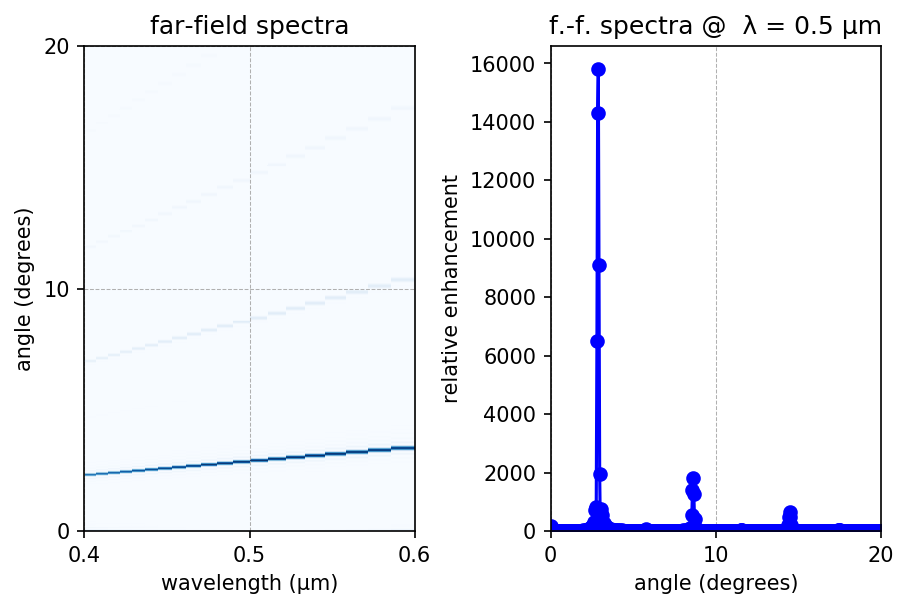

In [2]:
freqs = mp.get_near2far_freqs(n2f_obj)
wvl = np.divide(1, freqs)
ff_lengths = np.linspace(0, ff_length, ff_npts)
angles = [math.degrees(math.atan(f)) for f in ff_lengths / ff_distance]

wvl_slice = 0.5
idx_slice = np.where(np.asarray(freqs) == 1 / wvl_slice)[0][0]

rel_enh = np.absolute(ff_unitcell["Ez"]) ** 2 / np.absolute(ff_source["Ez"]) ** 2

plt.figure(dpi=150)

plt.subplot(1, 2, 1)
plt.pcolormesh(wvl, angles, rel_enh, cmap="Blues", shading="flat")
plt.axis([wvl_min, wvl_max, 0, ff_angle])
plt.xlabel("wavelength (μm)")
plt.ylabel("angle (degrees)")
plt.grid(linewidth=0.5, linestyle="--")
plt.xticks([t for t in np.arange(wvl_min, wvl_max + 0.1, 0.1)])
plt.yticks([t for t in range(0, ff_angle + 1, 10)])
plt.title("far-field spectra")

plt.subplot(1, 2, 2)
plt.plot(angles, rel_enh[:, idx_slice], "bo-")
plt.xlim(0, ff_angle)
plt.ylim(0)
plt.xticks([t for t in range(0, ff_angle + 1, 10)])
plt.xlabel("angle (degrees)")
plt.ylabel("relative enhancement")
plt.grid(axis="x", linewidth=0.5, linestyle="--")
plt.title("f.-f. spectra @  λ = {:.1} μm".format(wvl_slice))

plt.tight_layout(pad=0.5)
plt.show()

For the case of `nperiods = 1`, three diffraction orders are present in the far-field spectra as broad peaks with finite angular width (a fourth peak/order is also visible). When `nperiods = 10`, the diffraction orders become sharp, narrow peaks. The three diffraction orders are labeled in the right inset of the bottom figure as m=1, 3, and 5 corresponding to angles 2.9°, 8.6°, and 14.5° which, along with the diffraction efficiency, can be computed analytically using scalar theory as described in [Tutorials/Mode Decomposition/Diffraction Spectrum of a Binary Grating](https://meep.readthedocs.io/en/latest/Python_Tutorials/Mode_Decomposition/#diffraction-spectrum-of-a-binary-grating). As an additional validation of the simulation results, the ratio of any two diffraction peaks p<sub>a</sub>/p<sub>b</sub> (a,b = 1,3,5,...) is consistent with that of its diffraction efficiencies: b<sup>2</sup>/a<sup>2</sup>.

Finally, we verify that the error in `add_near2far` &mdash; defined as the L<sub>2</sub>-norm of the difference of the two far-field datasets from the unit- and super-cell calculations normalized by `nperiods` &mdash; is O(1/`nperiods`) by comparing results for three values of `nperiods`: 5, 10, and 20. The error values, which are displayed in the output in the line prefixed by `error:`, are: `0.0001195599054639075`, `5.981324591508146e-05`, and `2.989829913961854e-05`. The pairwise ratios of these errors is nearly 2 as expected (i.e., doubling `nperiods` results in halving the error).

For a single process, the far-field calculation in both runs takes roughly the same amount of time. The wall-clock time is indicated by the `getting farfields` category of the `Field time usage` statistics displayed as part of the output after time stepping is complete. Time-stepping a supercell, however, which for `nperiods=20` is more than 41 times larger than the unit cell (because of the PML termination) results in a total wall-clock time that is more than 40% larger. The slowdown is also due to the requirement of computing 41 times as many Fourier-transformed near fields. Thus, in the case of the unit-cell simulation, the reduced accuracy is a tradeoff for shorter runtime and less storage. In this example which involves multiple output wavelengths, the time for the far-field calculation can be reduced further on a single, shared-memory, multi-core machine via [multithreading](https://en.wikipedia.org/wiki/Thread_(computing)#Multithreading) by compiling Meep with OpenMP and specifying the environment variable `OMP_NUM_THREADS` to be an integer greater than one prior to execution.